In [ ]:
!pip install statsmodels
import urllib
from urllib import request
import re
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network  import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
url = 'https://raw.githubusercontent.com/hqr999/Projeto-Dirigido/main/Ouro_Novo.xlsx%20-%20Planilha2(1).csv'
gold_data = pd.read_csv(url,sep=",")

In [ ]:
df = pd.DataFrame(gold_data)
print(df)

           Data  Abertura  Máxima   Mínima  Fechamento
0      3/1/2017   124.200  124.20  124.200     124.200
1      3/2/2017   123.500  123.50  121.500     123.500
2      3/3/2017   123.799  123.80  123.000     123.700
3      3/6/2017   122.999  123.00  121.500     121.700
4      3/7/2017   121.650  121.65  120.800     120.800
...         ...       ...     ...      ...         ...
1226  2/22/2022   308.000  309.50  305.000     305.000
1227  2/23/2022   303.010  305.25  303.000     305.250
1228  2/24/2022   319.000  323.00  312.000     317.500
1229  2/25/2022   317.500  317.50  307.012     307.012
1230   3/2/2022   312.501  316.00  311.010     315.010

[1231 rows x 5 columns]


In [ ]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231 entries, 0 to 1230
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        1231 non-null   object 
 1   Abertura    1231 non-null   float64
 2   Máxima      1231 non-null   float64
 3   Mínima      1231 non-null   float64
 4   Fechamento  1231 non-null   float64
dtypes: float64(4), object(1)
memory usage: 48.2+ KB


In [ ]:
#Quantidade de valores perdidos
gold_data.isnull().sum()

Data          0
Abertura      0
Máxima        0
Mínima        0
Fechamento    0
dtype: int64

In [ ]:
#Pegando as estatísticas de medição
gold_data.describe()

,Abertura,Máxima,Mínima,Fechamento
count,1231.000000,1231.000000,1231.000000,1231.000000
mean,218.826033,220.558921,217.172805,218.986706
std,78.799133,79.608366,77.903537,78.785718
min,120.799000,121.000000,120.201000,120.500000
25%,146.100000,147.500000,145.550000,147.000000
50%,202.260000,204.500000,200.000000,202.650000
75%,305.580000,308.000000,304.000000,306.000000
max,350.001000,357.500000,350.000000,356.000000


In [ ]:
#Criando médias móveis semanais e mensais
gold_data['MM_7D'] = gold_data['Fechamento'].rolling(7).mean()
gold_data['MM_30D'] = gold_data['Fechamento'].rolling(30).mean()
gold_data['Retorno'] = gold_data['Fechamento'].pct_change()
gold_data['Variação'] = (gold_data['Fechamento']/gold_data['Abertura'])-1
gold_data['Volatilidade'] = gold_data['Retorno'].rolling(5).std()
#gold_data['Corpo do candle'] = ((gold_data['Fechamento']/gold_data['Abertura'])-1)*100
gold_data.dropna(inplace=True)
gold_data

,Data,Abertura,Máxima,Mínima,Fechamento,MM_7D,MM_30D,Retorno,Variação,Volatilidade
29,4/11/2017,127.480,127.80,126.000,127.500,125.735714,123.448667,0.011905,0.000157,0.011558
30,4/12/2017,128.600,129.50,127.500,129.500,126.535714,123.625333,0.015686,0.006998,0.011738
31,4/13/2017,128.490,129.00,128.490,129.000,127.178571,123.808667,-0.003861,0.003969,0.011488
32,4/17/2017,128.000,128.40,126.500,126.550,127.500000,123.903667,-0.018992,-0.011328,0.014933
33,4/18/2017,127.000,128.60,127.000,128.600,127.807143,124.133667,0.016199,0.012598,0.015315
...,...,...,...,...,...,...,...,...,...,...
1226,2/22/2022,308.000,309.50,305.000,305.000,311.571429,311.596400,-0.037855,-0.009740,0.047455
1227,2/23/2022,303.010,305.25,303.000,305.250,310.607143,311.054733,0.000820,0.007392,0.046987
1228,2/24/2022,319.000,323.00,312.000,317.500,311.964286,310.964733,0.040131,-0.004702,0.037418
1229,2/25/2022,317.500,317.50,307.012,307.012,312.394571,310.498467,-0.033033,-0.033033,0.034038


In [ ]:
#Construção do alvo
gold_data['Alvo'] = gold_data['Fechamento'].shift(-1) #Alvo do modelo é o fechamento do dia seguinte.
gold_data

,Data,Abertura,Máxima,Mínima,Fechamento,MM_7D,MM_30D,Retorno,Variação,Volatilidade,Alvo
29,4/11/2017,127.480,127.80,126.000,127.500,125.735714,123.448667,0.011905,0.000157,0.011558,129.500
30,4/12/2017,128.600,129.50,127.500,129.500,126.535714,123.625333,0.015686,0.006998,0.011738,129.000
31,4/13/2017,128.490,129.00,128.490,129.000,127.178571,123.808667,-0.003861,0.003969,0.011488,126.550
32,4/17/2017,128.000,128.40,126.500,126.550,127.500000,123.903667,-0.018992,-0.011328,0.014933,128.600
33,4/18/2017,127.000,128.60,127.000,128.600,127.807143,124.133667,0.016199,0.012598,0.015315,128.000
...,...,...,...,...,...,...,...,...,...,...,...
1226,2/22/2022,308.000,309.50,305.000,305.000,311.571429,311.596400,-0.037855,-0.009740,0.047455,305.250
1227,2/23/2022,303.010,305.25,303.000,305.250,310.607143,311.054733,0.000820,0.007392,0.046987,317.500
1228,2/24/2022,319.000,323.00,312.000,317.500,311.964286,310.964733,0.040131,-0.004702,0.037418,307.012
1229,2/25/2022,317.500,317.50,307.012,307.012,312.394571,310.498467,-0.033033,-0.033033,0.034038,315.010


## Correlação entre as colunas e o Dataset

In [ ]:
correlacao = gold_data.corr()

<AxesSubplot:>

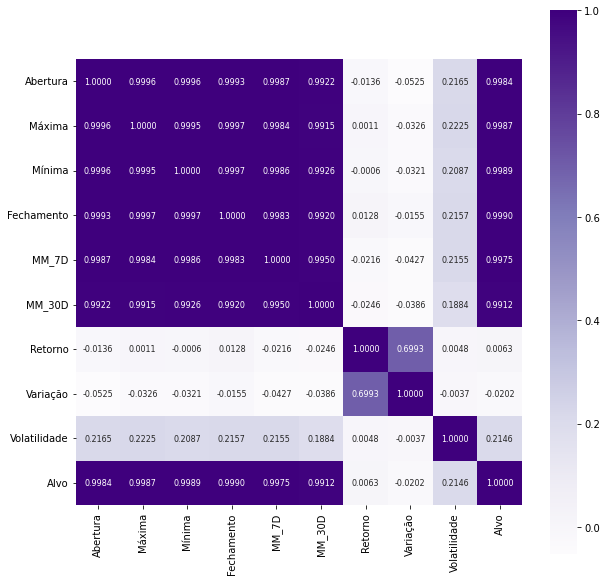

In [ ]:
#Vamos usar um mapa de calor para entender a correlação
#correl_heatmap = gold_data.drop(['Máxima','Mínima','Fechamento','Abertura'],axis=1).corr()
plt.figure(figsize = (10,10))
sns.heatmap(correlacao,cbar=True,square=True,fmt='.4f',annot=True,annot_kws={'size': 8},cmap='Purples')

In [ ]:
#valores de correlação do fechamento
print(correlacao['Alvo'])

Abertura        0.998422
Máxima          0.998716
Mínima          0.998880
Fechamento      0.998993
MM_7D           0.997451
MM_30D          0.991199
Retorno         0.006348
Variação       -0.020215
Volatilidade    0.214563
Alvo            1.000000
Name: Alvo, dtype: float64


/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fechamento', ylabel='Density'>

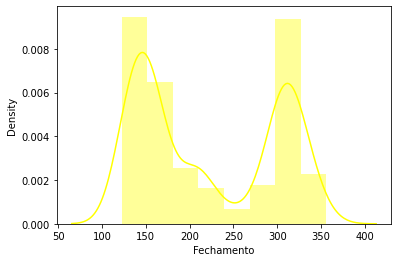

In [ ]:
#Checando a distribuição do fechamento
sns.distplot(gold_data['Fechamento'],color='yellow')

In [ ]:
# to explicitly convert the date column to type DATETIME
gold_data['Data'] = pd.to_datetime(gold_data['Data'])
gold_data = gold_data.set_index('Data')

In [ ]:
copia_completo = pd.DataFrame(gold_data.loc['2021-03-01':'2022-03-01'])
print(copia_completo)

            Abertura  Máxima   Mínima  Fechamento       MM_7D      MM_30D  \
Data                                                                        
2021-03-01    309.00  310.00  306.700     307.200  309.557143  313.349433   
2021-03-02    313.00  314.00  309.500     310.000  309.842857  313.382767   
2021-03-03    313.00  315.50  307.500     307.500  309.057143  313.332733   
2021-03-04    303.30  307.60  303.300     307.000  308.342857  313.122733   
2021-03-05    308.00  308.00  304.950     305.100  307.642857  312.759567   
...              ...     ...      ...         ...         ...         ...   
2022-02-21    307.00  318.00  302.790     317.000  312.500000  312.223067   
2022-02-22    308.00  309.50  305.000     305.000  311.571429  311.596400   
2022-02-23    303.01  305.25  303.000     305.250  310.607143  311.054733   
2022-02-24    319.00  323.00  312.000     317.500  311.964286  310.964733   
2022-02-25    317.50  317.50  307.012     307.012  312.394571  310.498467   

# Separando dados de treino e validação

In [ ]:
#Dividindo alvo e features
X_train = gold_data.loc[:'2022-03-01'].drop(['Alvo','Variação'],axis=1)
Y_train = gold_data.loc[:'2022-03-01','Alvo']
X_test = gold_data.loc['2021-03-01':'2022-03-01'].drop(['Alvo','Variação'],axis=1)
Y_test = gold_data.loc['2021-03-01':'2022-03-01','Alvo']

In [ ]:
X_train

,Abertura,Máxima,Mínima,Fechamento,MM_7D,MM_30D,Retorno,Volatilidade
Data,,,,,,,,
2017-04-11,127.48,127.80,126.000,127.500,125.735714,123.448667,0.011905,0.011558
2017-04-12,128.60,129.50,127.500,129.500,126.535714,123.625333,0.015686,0.011738
2017-04-13,128.49,129.00,128.490,129.000,127.178571,123.808667,-0.003861,0.011488
2017-04-17,128.00,128.40,126.500,126.550,127.500000,123.903667,-0.018992,0.014933
2017-04-18,127.00,128.60,127.000,128.600,127.807143,124.133667,0.016199,0.015315
...,...,...,...,...,...,...,...,...
2022-02-21,307.00,318.00,302.790,317.000,312.500000,312.223067,0.022581,0.043782
2022-02-22,308.00,309.50,305.000,305.000,311.571429,311.596400,-0.037855,0.047455
2022-02-23,303.01,305.25,303.000,305.250,310.607143,311.054733,0.000820,0.046987


In [ ]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)
print(X_test_scale)
print(X_train_scale)

[[0.82056534 0.79761398 0.810669   ... 0.87554912 0.4416592  0.01161788]
 [0.83807073 0.81465701 0.82291211 ... 0.8757028  0.51696679 0.10461241]
 [0.83807073 0.82104815 0.81416703 ... 0.87547212 0.39650388 0.11291439]
 ...
 [0.79435101 0.77737537 0.7944906  ... 0.86496926 0.45880139 0.98988592]
 [0.86432882 0.85300383 0.83384346 ... 0.86455431 0.73445973 0.78289699]
 [0.8577643  0.82956966 0.81203323 ... 0.86240456 0.22141991 0.70979857]]
[[2.61705638e-02 2.13037921e-02 2.05509401e-02 ... 0.00000000e+00
  5.36532022e-01 2.23557899e-01]
 [3.10720741e-02 2.85470814e-02 2.71097508e-02 ... 8.14532489e-04
  5.63048664e-01 2.27442022e-01]
 [3.05906758e-02 2.64167022e-02 3.14385658e-02 ... 1.65980205e-03
  4.25979657e-01 2.22039709e-01]
 ...
 [7.94351009e-01 7.77375373e-01 7.94490599e-01 ... 8.64969263e-01
  4.58801393e-01 9.89885916e-01]
 [8.64328821e-01 8.53003835e-01 8.33843463e-01 ... 8.64554312e-01
  7.34459725e-01 7.82896992e-01]
 [8.57764299e-01 8.29569663e-01 8.12033231e-01 ... 8.624

# Test Model Random Forrest Regressor

Random Forrest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=10)

In [ ]:
rf.fit(X_train_scale,Y_train)

RandomForestRegressor(n_estimators=10)

In [ ]:
#predicao nos dados de teste
predicao = rf.predict(X_test_scale)

In [ ]:
print(predicao) 

[310.01   308.75   307.25   305.68   309.05   313.12   314.9137 306.516
 306.2    309.2    309.6    310.8486 308.75   305.02   305.48   305.7003
 309.389  310.5598 315.2    314.16   312.6    307.5498 310.6698 312.8275
 310.0998 313.74   312.393  313.75   315.471  315.33   314.138  314.851
 316.421  314.3001 313.95   310.34   310.     308.4006 306.405  306.9899
 304.15   305.6002 308.7    309.999  305.425  306.1    305.8    306.45
 305.5502 306.11   306.8602 309.9    310.78   312.15   314.5    316.435
 317.781  318.411  323.5    320.9    320.6    317.74   316.2101 313.0608
 311.54   307.0017 308.2902 305.67   306.7    305.5802 306.5    303.9612
 300.65   295.3509 289.6855 283.0901 281.3455 280.5202 280.6001 277.0506
 279.8245 281.0499 278.725  279.525  284.025  285.7001 292.065  296.5634
 299.855  299.65   299.5864 298.9399 296.16   298.8494 297.     300.0005
 301.926  299.399  299.1849 299.051  296.8    297.1001 297.18   297.4002
 301.3191 302.605  299.3899 301.065  300.76   296.61   2

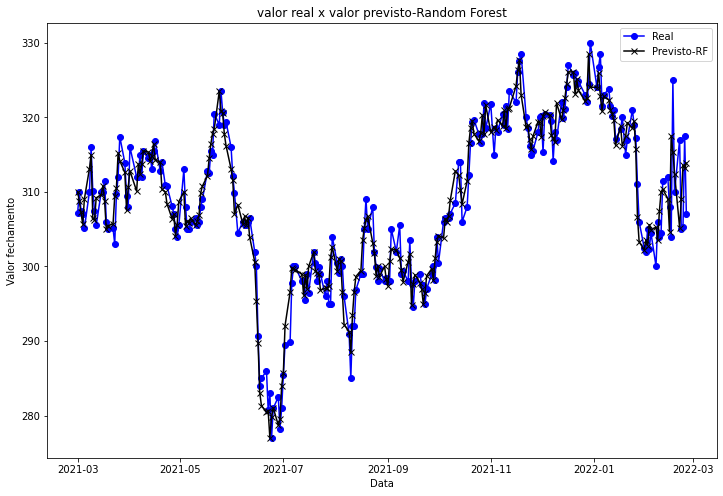

In [ ]:
copia_completo['previsao-RF'] = predicao
#plotagem
plt.figure(figsize=(12,8))
plt.title('valor real x valor previsto-Random Forest')
plt.plot(copia_completo['Fechamento'],label = "Real", color = "blue", marker = 'o')
plt.plot(copia_completo['previsao-RF'],label = "Previsto-RF", color = "black",marker='x')
plt.xlabel('Data')
plt.ylabel('Valor fechamento')
plt.legend()

In [ ]:
rf.score(X_test_scale,Y_test)

0.9690268830147781

In [ ]:
#Erro quadrado
erro = metrics.r2_score(Y_test,predicao)
print(erro)

0.9690268830147781


# Test Model Linear Regression

Regressão Linear

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train_scale,Y_train)

LinearRegression()

In [ ]:
prever = lr.predict(X_test_scale)

In [ ]:
print(prever)

[307.45514553 310.3956731  308.3092212  306.5948203  305.71066896
 309.72787857 317.12772833 311.41543705 307.94510769 305.70945846
 310.90633734 310.31952703 311.81540084 306.65293662 304.90517352
 305.83919346 303.68018754 307.99299676 311.89011227 316.40461056
 314.89700797 310.4260296  308.32863193 315.16652921 312.45686258
 312.44876039 313.82990834 312.55609394 315.50715987 313.34027382
 315.75308867 313.81341281 315.22064021 316.57482134 313.53224421
 313.54019591 311.42871417 311.3920135  308.78079662 307.69588064
 304.96176616 303.85399704 304.94631502 312.31161394 308.58606372
 306.01628451 305.99524503 306.04977993 306.34429526 306.36439171
 306.42752551 307.82658726 309.17440323 312.37210347 312.81583796
 315.93104787 315.81782261 318.74305955 319.44294349 322.96854479
 322.01709142 319.40125405 319.26233073 316.5326904  312.1466771
 309.50797297 304.95677984 305.79391781 305.2377442  306.31171026
 306.28398502 306.46211669 302.53924369 300.77308826 291.34276021
 284.691782

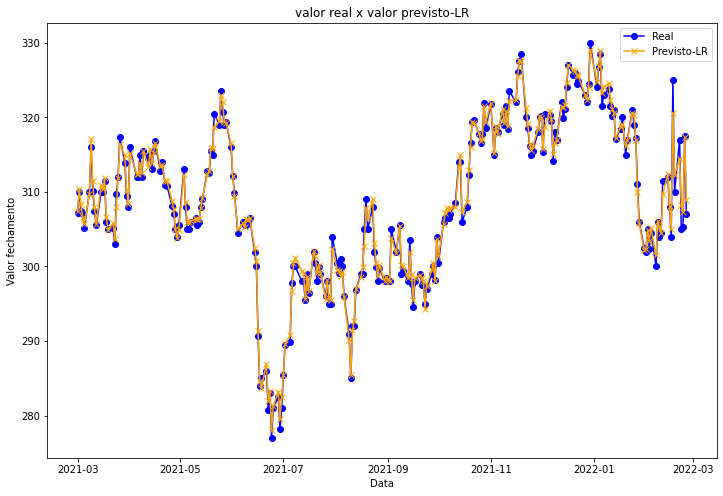

In [ ]:
copia_completo['previsao-LR'] = prever
#plotagem
plt.figure(figsize=(12,8))
plt.title('valor real x valor previsto-LR')
plt.plot(copia_completo['Fechamento'],label = "Real", color = "blue", marker = 'o')
plt.plot(copia_completo['previsao-LR'],label = "Previsto-LR", color = "orange",marker='x')
plt.xlabel('Data')
plt.ylabel('Valor fechamento')
plt.legend()

In [ ]:
#Erro quadrado
erro2 = metrics.r2_score(Y_test,prever)
print(erro2)

0.8726556591270596


# Test Model KNN

KNN

In [ ]:
kn = KNeighborsRegressor()

In [ ]:
kn.fit(X_train_scale,Y_train)

KNeighborsRegressor()

In [ ]:
preeee = kn.predict(X_test_scale)

In [ ]:
print(preeee)

[308.2004 312.92   306.7206 306.34   306.64   314.48   314.45   310.2
 309.6    307.98   314.458  312.1196 311.0002 308.5    309.7136 305.3202
 303.78   308.5    313.978  314.1    310.5    309.2    309.0136 312.88
 309.2    311.75   313.9354 310.1    315.558  316.85   316.382  316.85
 316.792  317.652  314.5802 310.8022 311.66   310.3402 306.7206 306.64
 306.3    305.1004 309.18   312.     311.5    309.994  307.98   308.42
 306.8202 306.02   309.1604 308.9604 308.9604 313.16   313.32   312.92
 315.332  318.45   319.85   320.85   319.6202 318.98   318.852  319.9802
 308.5006 306.7006 305.8204 305.3202 305.3202 305.3202 306.8202 309.1604
 301.6804 301.18   291.2002 287.6998 283.9482 281.5004 285.4998 281.5004
 284.3998 281.8902 280.8002 285.4998 281.8902 285.0022 287.91   286.2602
 301.678  299.1    298.4902 299.3798 298.4898 298.5998 298.1    296.7002
 303.42   300.9798 299.78   299.49   300.3598 295.9998 298.9    296.6002
 298.     302.614  297.7198 299.422  302.934  298.102  296.6002 

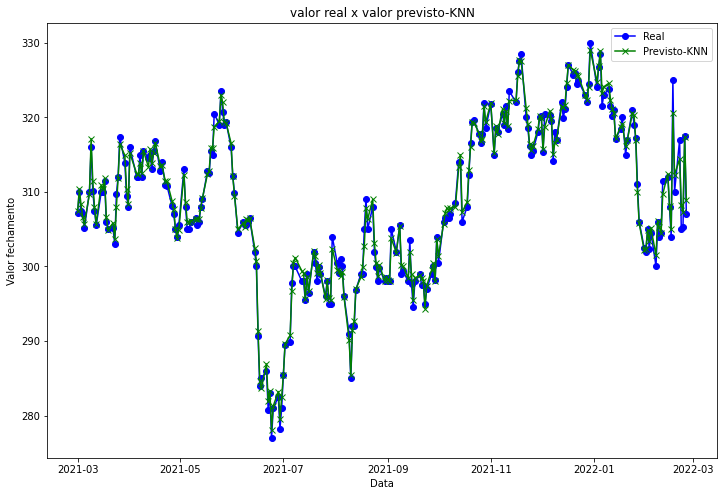

In [ ]:
copia_completo['previsao-KNN'] = prever
#plotagem
plt.figure(figsize=(12,8))
plt.title('valor real x valor previsto-KNN')
plt.plot(copia_completo['Fechamento'],label = "Real", color = "blue", marker = 'o')
plt.plot(copia_completo['previsao-KNN'],label = "Previsto-KNN", color = "green",marker='x')
plt.xlabel('Data')
plt.ylabel('Valor fechamento')
plt.legend()

In [ ]:
#erro quadrado
erro3 = metrics.r2_score(Y_test,preeee)
print(erro3)

0.884274535561245


# Test Model Neural Network

Neural networks

In [ ]:
nn = MLPRegressor(solver='lbfgs',max_iter=2000)

In [ ]:
nn.fit(X_train_scale,Y_train)

MLPRegressor(max_iter=2000, solver='lbfgs')

In [ ]:
p4 = nn.predict(X_test_scale)

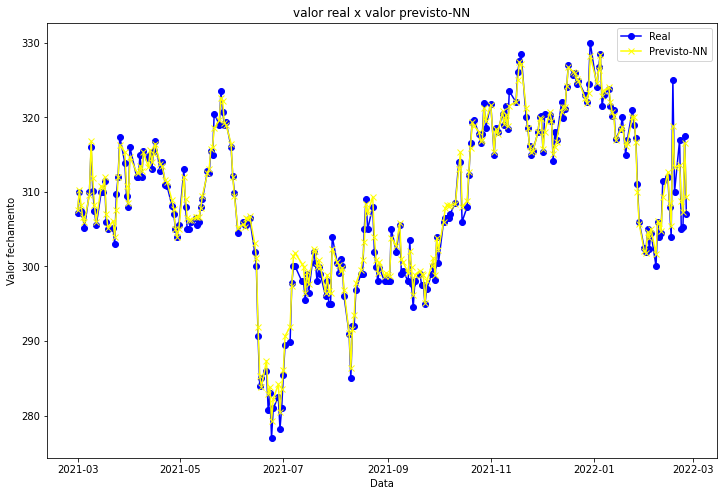

In [ ]:
copia_completo['previsao-NN'] = p4
#plotagem
plt.figure(figsize=(12,8))
plt.title('valor real x valor previsto-NN')
plt.plot(copia_completo['Fechamento'],label = "Real", color = "blue", marker = 'o')
plt.plot(copia_completo['previsao-NN'],label = "Previsto-NN", color = "yellow",marker='x')
plt.xlabel('Data')
plt.ylabel('Valor fechamento')
plt.legend()

In [ ]:
#erro quadrado
erro4 = metrics.r2_score(Y_test,p4)
print(erro4)

0.8763868351234552


# Test Model SVM

Support Vector Machine

In [ ]:
svm = SVR(gamma='auto')

In [ ]:
svm.fit(X_train_scale,Y_train)

SVR(gamma='auto')

In [ ]:
p5 = svm.predict(X_test_scale)

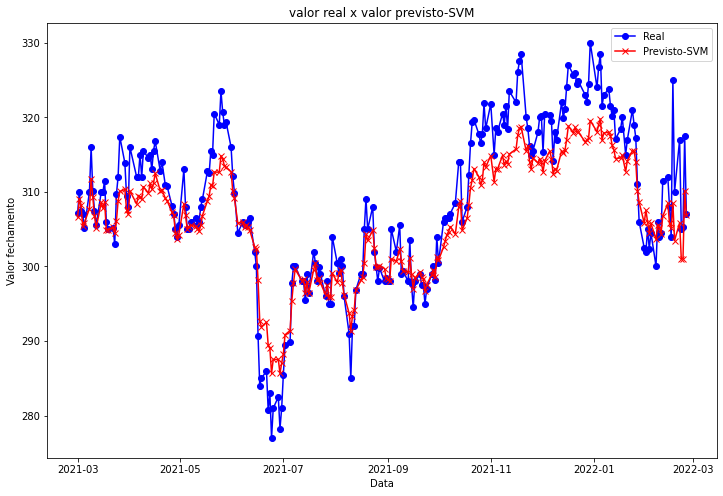

In [ ]:
copia_completo['previsao-SVM'] = p5
#plotagem
plt.figure(figsize=(12,8))
plt.title('valor real x valor previsto-SVM')
plt.plot(copia_completo['Fechamento'],label = "Real", color = "blue", marker = 'o')
plt.plot(copia_completo['previsao-SVM'],label = "Previsto-SVM", color = "red",marker='x')
plt.xlabel('Data')
plt.ylabel('Valor fechamento')
plt.legend()

In [ ]:
#erro quadrado
erro5 = metrics.r2_score(Y_test,p5)
print(erro5)

0.7634964269222139


# Gráfico comparando a previsão de cada algoritmo

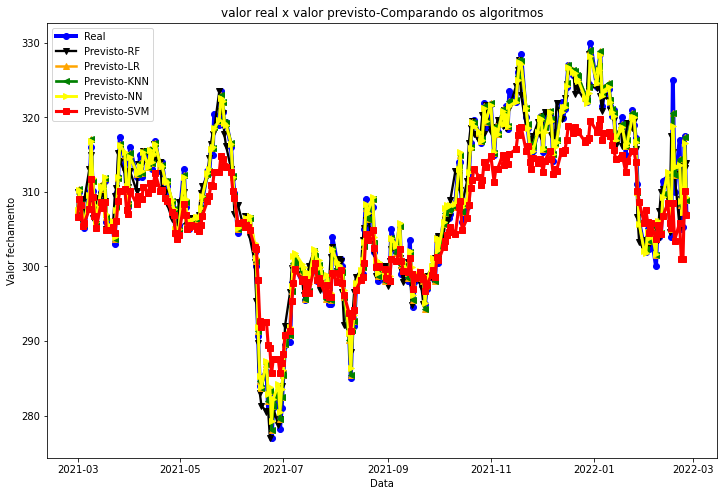

In [ ]:
#plotagem
plt.figure(figsize=(12,8))
plt.title('valor real x valor previsto-Comparando os algoritmos')
plt.plot(copia_completo['Fechamento'],linewidth=4,label = "Real", color = "blue", marker = 'o')
plt.plot(copia_completo['previsao-RF'],linewidth=2.3,label = "Previsto-RF", color = "black",marker='v')
plt.plot(copia_completo['previsao-LR'],linewidth=2.5,label = "Previsto-LR", color = "orange",marker='^')
plt.plot(copia_completo['previsao-KNN'],linewidth=2.7,label = "Previsto-KNN", color = "green",marker='<')
plt.plot(copia_completo['previsao-NN'],linewidth=2.9,label = "Previsto-NN", color = "yellow",marker='>')
plt.plot(copia_completo['previsao-SVM'],linewidth=3.1,label = "Previsto-SVM", color = "red",marker='s')
plt.xlabel('Data')
plt.ylabel('Valor fechamento')
plt.legend()

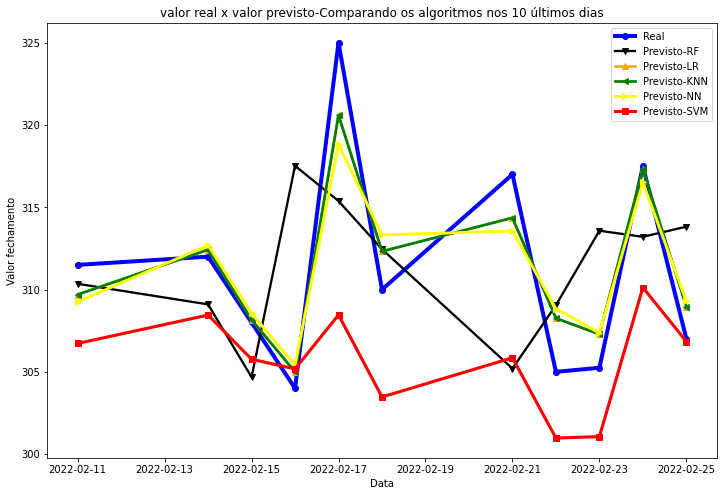

In [ ]:
plt.figure(figsize=(12,8))
plt.title('valor real x valor previsto-Comparando os algoritmos nos 10 últimos dias')
plt.plot(copia_completo['Fechamento'].loc['2022-02-11':],linewidth=4,label = "Real", color = "blue", marker = 'o')
plt.plot(copia_completo['previsao-RF'].loc['2022-02-11':],linewidth=2.3,label = "Previsto-RF", color = "black",marker='v')
plt.plot(copia_completo['previsao-LR'].loc['2022-02-11':],linewidth=2.5,label = "Previsto-LR", color = "orange",marker='^')
plt.plot(copia_completo['previsao-KNN'].loc['2022-02-11':],linewidth=2.7,label = "Previsto-KNN", color = "green",marker='<')
plt.plot(copia_completo['previsao-NN'].loc['2022-02-11':],linewidth=2.9,label = "Previsto-NN", color = "yellow",marker='>')
plt.plot(copia_completo['previsao-SVM'].loc['2022-02-11':],linewidth=3.1,label = "Previsto-SVM", color = "red",marker='s')
plt.xlabel('Data')
plt.ylabel('Valor fechamento')
plt.legend()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

LR: 0.914615 (0.044950)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lb

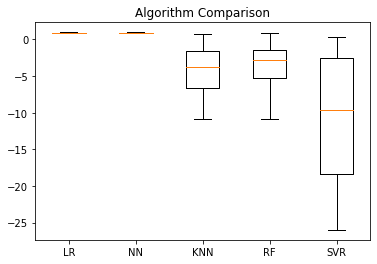

In [ ]:
#BOXPLOT
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 100))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=4)
    
 cv_results = cross_val_score(model, X_train_scale, Y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

# Métricas de análise de regressão

In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Métricas de Regressão
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))#Erro Médio Absoluto
    print('MSE: ', round(mse,4))#Erro Quadrático Médio
    print('RMSE: ', round(np.sqrt(mse),4))#Erro Quadrado Médio de Raiz

In [ ]:
y_true = Y_test
y_pred = predicao
regression_results(y_true, y_pred)

explained_variance:  0.969
mean_squared_log_error:  0.0
r2:  0.969
MAE:  1.3317
MSE:  3.6154
RMSE:  1.9014


In [ ]:
y_true = Y_test
y_pred = prever
regression_results(y_true, y_pred)

explained_variance:  0.873
mean_squared_log_error:  0.0002
r2:  0.8727
MAE:  2.945
MSE:  14.8645
RMSE:  3.8554


In [ ]:
y_true = Y_test
y_pred = preeee
regression_results(y_true, y_pred)

explained_variance:  0.8856
mean_squared_log_error:  0.0001
r2:  0.8843
MAE:  2.8121
MSE:  13.5082
RMSE:  3.6754


In [ ]:
y_true = Y_test
y_pred = p4
regression_results(y_true, y_pred)

explained_variance:  0.8774
mean_squared_log_error:  0.0002
r2:  0.8764
MAE:  2.912
MSE:  14.4289
RMSE:  3.7985


In [ ]:
y_true = Y_test
y_pred = p5
regression_results(y_true, y_pred)

explained_variance:  0.8053
mean_squared_log_error:  0.0003
r2:  0.7635
MAE:  4.0696
MSE:  27.6062
RMSE:  5.2542


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=416be4a5-1e2e-4be1-bf29-bebc5e018d70' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>